In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

- 사용자 별로 이전 대출 categorical 데이터를 count, numeric데이터를 agg
-  이전 대출의 매달 데이터를 count, agg하여 이전 대출 데이터와 병합
-  missing value가 90퍼 이상인 것 제거
- kdeplot생성 함수를 만들어서 target과 높은 corr을 갖는 feature을 kde plot 그리기
- column 간에 correlation이 0.8이상인 것을 제거
- lgb model 구현(features, test_features, encoding, n_folds)
    - label, id 분리
    - onehot encoding, lable encoding 구현
    - array로 변환
    - kfold 선언
    - feature_importance_values, test_predictions, out_of_fold, valid_scores, train_scores 생성

In [2]:
train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv')

In [3]:
print('Training Data Shape: ', train.shape)
train.head()

Training Data Shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print('Testing Data Shape: ', test.shape)
test.head()

Testing Data Shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print('Bureau data Shape: ',bureau.shape)
bureau.head()

Bureau data Shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
print('bureau balance data shape: ', bureau_balance.shape)
bureau_balance.head()

bureau balance data shape:  (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [7]:
bureau_balance[['SK_ID_BUREAU','MONTHS_BALANCE']].groupby('SK_ID_BUREAU').agg(['mean','count']).reset_index().columns.levels[1]

Index(['mean', 'count', ''], dtype='object')

In [8]:
def count_categorical(df, group_var, df_name):
    
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]

    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])

    columns = []

    for var in categorical.columns.levels[0]:
        for stat in categorical.columns.levels[1]:
            columns.append('%s_%s_%s'%(df_name,var, stat))

    categorical.columns = columns
    
    return categorical

def agg_numeric(df, group_var, df_name):
    
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    numeric_table = df.groupby(group_var).agg(['mean','min','max','count','sum']).reset_index()
    
    columns = [group_var]
    
    for var in numeric_table.columns.levels[0]:
        if var != group_var:
            for stat in numeric_table.columns.levels[1][:-1]:
                columns.append('%s_%s_%s'%(df_name, var, stat))
    numeric_table.columns = columns
    
    return numeric_table

In [9]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')


In [10]:
original_features = list(train.columns)
print('Original Number of Features', len(original_features))

Original Number of Features 122


In [11]:
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how='left')
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how='left')
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how='left')

In [12]:
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how='left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how='left')
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how='left')

In [13]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


In [14]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = df.isnull().sum() / len(df) * 100
    
    mis_val_table = pd.concat([mis_val,mis_val_percent], axis =1).rename(columns = {0:'Missing Values',1:'% of Total Values'})
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1]!=0].sort_values('% of Total Values', ascending = False).round(1)
    
    return mis_val_table

In [15]:
missing_train = missing_values_table(train)
missing_train.head()

,Missing Values,% of Total Values
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_MONTHS_BALANCE_mean_max,215280,70.0
client_bureau_balance_MONTHS_BALANCE_max_mean,215280,70.0


In [16]:
missing_train_vars = list(missing_train[missing_train.iloc[:,1]>90].index)
print(len(missing_train_vars))

0


In [17]:
missing_test = missing_values_table(test)
missing_test.head()

,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4


In [18]:
missing_test_vars = list(missing_test[missing_test.iloc[:,1]>90].index)
print(len(missing_test_vars))

0


In [19]:
train_labels = train['TARGET']
train, test = train.align(test, join='inner', axis =1)
train['TARGET'] = train_labels

In [20]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [21]:
corrs = train.corr()

In [22]:
corrs = corrs.sort_values('TARGET', ascending = False)
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_mean,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [23]:
plt.style.use('fivethirtyeight')

In [24]:
def kde_plot(feature, df):
    median_repaid = df.loc[df['TARGET']==0, feature].median()
    median_not_repaid = df.loc[df['TARGET']==1, feature].median()
    
    plt.figure(figsize = (12, 6))
    sns.kdeplot(df.loc[df['TARGET']==0, feature], label='target==0')
    sns.kdeplot(df.loc[df['TARGET']==1, feature], label='target==1')
    
    plt.title('%s Distibution'%(feature)); plt.ylabel('Density'); plt.xlabel('%s'%feature)
    
    plt.legend()
    print('corr: ', df['TARGET'].corr(df[feature]))
    print('median value of repaid %0.4f'%median_repaid)
    print('median value of not repaid %0.4f'%median_not_repaid)

corr:  0.07642449076705937
median value of repaid -20.2500
median value of not repaid -16.4129


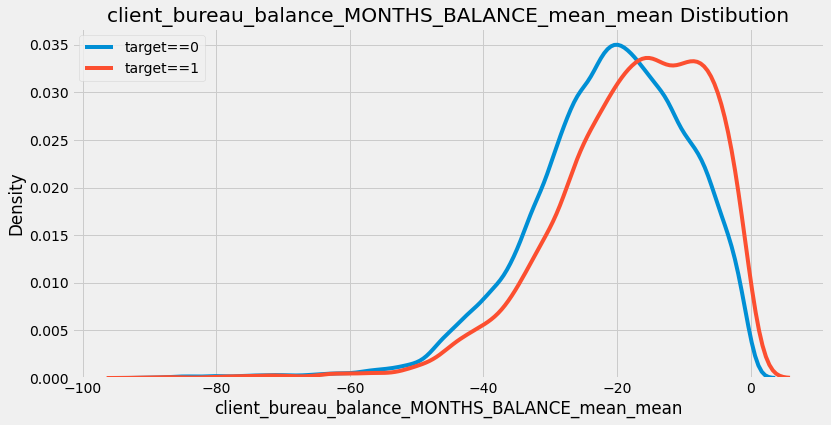

In [25]:
kde_plot('client_bureau_balance_MONTHS_BALANCE_mean_mean',train)

In [26]:
corrs

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_bureau_balance_STATUS_X_sum_min,client_bureau_balance_STATUS_X_sum_max,client_bureau_balance_STATUS_X_sum_count,client_bureau_balance_STATUS_X_sum_sum,client_bureau_balance_STATUS_X_mean_mean,client_bureau_balance_STATUS_X_mean_min,client_bureau_balance_STATUS_X_mean_max,client_bureau_balance_STATUS_X_mean_count,client_bureau_balance_STATUS_X_mean_sum,TARGET
TARGET,-0.002108,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932,0.041975,...,-0.014557,-0.030919,0.010669,-0.008445,0.000408,-0.001056,0.001110,0.010669,0.009862,1.000000
bureau_DAYS_CREDIT_mean,0.003636,0.026094,-0.008837,-0.084393,-0.066503,-0.086089,-0.019976,0.203135,-0.043686,0.096894,...,-0.157844,-0.307838,-0.026203,-0.113809,0.014804,0.058192,-0.047574,-0.026203,-0.013751,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.003236,0.021236,-0.025563,-0.083456,-0.058436,-0.085685,-0.013693,0.200788,-0.041321,0.091993,...,-0.157790,-0.307970,-0.128957,-0.245166,0.014839,0.058225,-0.047631,-0.128957,-0.061936,0.089038
DAYS_BIRTH,-0.001500,0.330938,0.027261,-0.055436,0.009445,-0.053442,-0.029582,1.000000,-0.615864,0.331912,...,-0.016743,-0.074272,-0.008141,-0.025157,-0.009988,0.014397,-0.032401,-0.008141,-0.009433,0.078239
bureau_CREDIT_ACTIVE_Active_mean,0.001229,0.013221,0.016527,-0.021280,-0.037859,-0.026544,0.015857,0.116114,-0.049473,0.046167,...,0.012146,-0.097456,-0.074026,-0.045975,0.139934,0.156642,0.034106,-0.074026,-0.007553,0.077356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bureau_CREDIT_ACTIVE_Closed_mean,-0.000463,-0.013071,-0.016815,0.021459,0.037671,0.026702,-0.017241,-0.115926,0.050521,-0.046846,...,-0.015712,0.092723,0.073930,0.044342,-0.142027,-0.158011,-0.036420,0.073930,0.006860,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.004068,-0.026412,0.023685,0.071355,0.071230,0.073737,0.027155,-0.160568,0.033628,-0.076290,...,0.222072,0.367959,0.045621,0.278595,0.004090,-0.028684,0.056408,0.045621,0.023920,-0.080193
EXT_SOURCE_1,0.000082,-0.138470,0.026232,0.168429,0.119398,0.175502,0.099997,-0.600610,0.289848,-0.181095,...,0.002111,0.097395,0.010779,0.035855,0.021582,-0.021389,0.061695,0.010779,0.015403,-0.155317
EXT_SOURCE_2,0.002342,-0.018015,0.060925,0.131228,0.125804,0.139367,0.198924,-0.091996,-0.020767,-0.059913,...,0.024821,0.055341,-0.000163,0.024739,0.032212,0.010258,0.034839,-0.000163,0.012558,-0.160472


In [27]:
threshold = 0.8

above_threshold_vars ={}

for col in corrs:
    above_threshold_vars[col] = list(corrs[corrs[col]>threshold].index)

In [28]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


In [29]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

In [30]:
print('Traning Corrs Removed Shape:',train_corrs_removed.shape)
print('Testing Corrs Removed Shape:',test_corrs_removed.shape)

Traning Corrs Removed Shape: (307511, 199)
Testing Corrs Removed Shape: (48744, 198)


In [31]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc
import matplotlib.pyplot as plt

In [32]:
def model(features, test_features, encoding = 'ohe', n_folds =5):
    labels = features['TARGET']
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    train = features.drop(columns = ['TARGET','SK_ID_CURR'])
    test = test_features.drop(columns = 'SK_ID_CURR')
    
    if encoding == 'ohe':
        train = pd.get_dummies(train)
        test = pd.get_dummies(test)
        
        train, test = train.align(test, join='inner', axis =1)
        cat_indices = 'auto'
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []
        
        for i, col in enumerate(train):
            if train[col] == 'object':
                train[col] = label_encoder.fit_transform(np.array(train[col].astype(str)).reshape(-1,))
                test[col] = label_encoder.transform(np.array(test[col].astype(str)).reshape(-1,))
                cat_indices.append(i)
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    print('Traing Data Shape:', train.shape)
    print('Testing Data Shape:', test.shape)
    
    feature_names = list(train.columns)
    
    train = np.array(train)
    test = np.array(test)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    feature_importance_values = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(len(test))
    out_of_fold = np.zeros(len(train))
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(train):
        train_features, train_labels = train[train_indices], labels[train_indices]
        valid_features, valid_labels = train[valid_indices], labels[valid_indices]
        
        model = lgb.LGBMClassifier(n_estimators = 10000
                                   , objective='binary'
                                   , class_weight = 'balanced'
                                   , learning_rate = 0.05
                                   , reg_alpha = 0.1
                                   , reg_lambda = 0.1
                                   , subsample = 0.8
                                   , n_jobs = -1
                                   , random_state= 50
                                  )
        model.fit(train_features
                 , train_labels
                 , eval_metric = 'auc'
                 , eval_set = [(valid_features, valid_labels), (train_features, train_labels)]
                 , eval_names =['valid','train']
                 , categorical_feature = cat_indices
                 , early_stopping_rounds = 100
                 , verbose = 200
        )
        best_iteration = model.best_iteration_
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_predictions += model.predict_proba(test, num_iteration = best_iteration)[:,1] / k_fold.n_splits
        
        out_of_fold[valid_indices] =model.predict_proba(valid_features, num_iteration = best_iteration)[:,1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    feature_importacne = pd.DataFrame({'feature':feature_names, 'importance':feature_importance_values})
    
    submission = pd.DataFrame({'SK_ID_CURR':test_ids, 'TARGET':test_predictions})
    
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold':fold_names, 'train':train_scores, 'valid': valid_scores})
    return submission, feature_importacne, metrics

In [33]:
def plot_feature_importances(df):
    df = df.sort_values('importance', ascending = False).reset_index()
    
    df['importance_nomalized'] = df['importance'] / df['importance'].sum()
    
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_nomalized'].head(15),
           align = 'center',
           edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized Importance')
    plt.ylabel('Feature Importances')
    plt.show()
    
    return df

In [34]:
train_control = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
test_control = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

In [35]:
submission, feature_importacne, metrics = model(train_control,test_control)

Traing Data Shape: (307511, 241)
Testing Data Shape: (48744, 241)
[200]	train's auc: 0.7989	train's binary_logloss: 0.547642	valid's auc: 0.755463	valid's binary_logloss: 0.563361
[400]	train's auc: 0.82864	train's binary_logloss: 0.518235	valid's auc: 0.755594	valid's binary_logloss: 0.544951
[200]	train's auc: 0.798638	train's binary_logloss: 0.547974	valid's auc: 0.758354	valid's binary_logloss: 0.56326
[200]	train's auc: 0.7977	train's binary_logloss: 0.549358	valid's auc: 0.763287	valid's binary_logloss: 0.564505
[200]	train's auc: 0.798947	train's binary_logloss: 0.547854	valid's auc: 0.757823	valid's binary_logloss: 0.562315
[200]	train's auc: 0.798357	train's binary_logloss: 0.548311	valid's auc: 0.758237	valid's binary_logloss: 0.564466


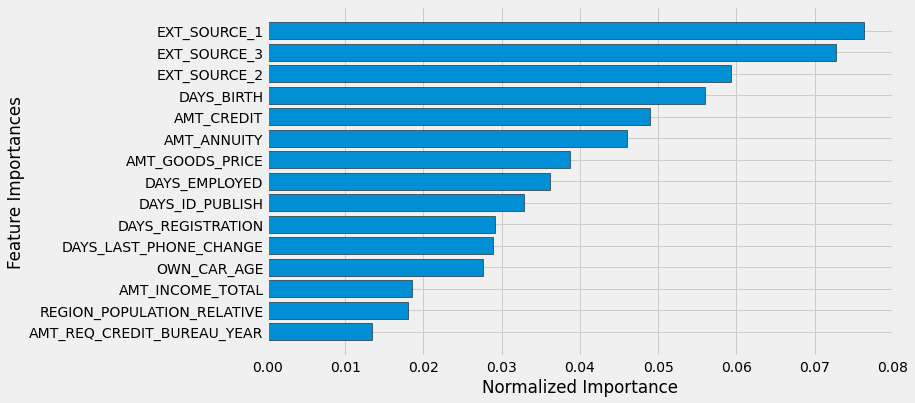

,index,feature,importance,importance_nomalized
0,27,EXT_SOURCE_1,627.0,0.076277
1,29,EXT_SOURCE_3,598.4,0.072798
2,28,EXT_SOURCE_2,487.8,0.059343
3,6,DAYS_BIRTH,460.6,0.056034
4,2,AMT_CREDIT,402.8,0.049002
...,...,...,...,...
236,96,FLAG_DOCUMENT_20,0.0,0.000000
237,173,ORGANIZATION_TYPE_Cleaning,0.0,0.000000
238,78,FLAG_DOCUMENT_2,0.0,0.000000
239,88,FLAG_DOCUMENT_12,0.0,0.000000


In [36]:
plot_feature_importances(feature_importacne)

In [37]:
metrics

,fold,train,valid
0,0,0.815791,0.755755
1,1,0.811912,0.758533
2,2,0.811252,0.763822
3,3,0.805899,0.758345
4,4,0.807459,0.758535
5,overall,0.810463,0.759002


In [38]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Traing Data Shape: (307511, 452)
Testing Data Shape: (48744, 452)
[200]	train's auc: 0.810821	train's binary_logloss: 0.53617	valid's auc: 0.763279	valid's binary_logloss: 0.553134
[200]	train's auc: 0.810727	train's binary_logloss: 0.53666	valid's auc: 0.765248	valid's binary_logloss: 0.553447
[200]	train's auc: 0.809569	train's binary_logloss: 0.538079	valid's auc: 0.770517	valid's binary_logloss: 0.55476
[200]	train's auc: 0.810367	train's binary_logloss: 0.537096	valid's auc: 0.765831	valid's binary_logloss: 0.552574
[200]	train's auc: 0.810433	train's binary_logloss: 0.536726	valid's auc: 0.76417	valid's binary_logloss: 0.554751


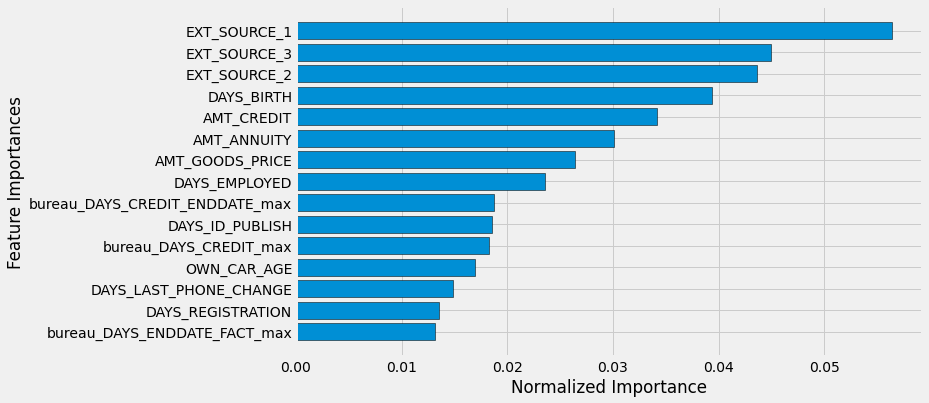

In [39]:
fi_raw_sorted = plot_feature_importances(fi_raw)

In [40]:
metrics_raw

,fold,train,valid
0,0,0.823660,0.763730
1,1,0.824682,0.766092
2,2,0.826798,0.771361
3,3,0.817720,0.766206
4,4,0.821525,0.764642
5,overall,0.822877,0.766404


In [41]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(feature_importacne['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

% of Top 100 Features created from the bureau data = 52.00


In [42]:
submission_raw.to_csv('test_one.csv', index = False)

In [43]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Traing Data Shape: (307511, 318)
Testing Data Shape: (48744, 318)
[200]	train's auc: 0.807062	train's binary_logloss: 0.539926	valid's auc: 0.761756	valid's binary_logloss: 0.555974
[200]	train's auc: 0.807403	train's binary_logloss: 0.539835	valid's auc: 0.762487	valid's binary_logloss: 0.556178
[200]	train's auc: 0.806206	train's binary_logloss: 0.541195	valid's auc: 0.766958	valid's binary_logloss: 0.557491
[400]	train's auc: 0.83864	train's binary_logloss: 0.508571	valid's auc: 0.767385	valid's binary_logloss: 0.536782
[200]	train's auc: 0.806561	train's binary_logloss: 0.540767	valid's auc: 0.763307	valid's binary_logloss: 0.556131
[200]	train's auc: 0.807104	train's binary_logloss: 0.540208	valid's auc: 0.760759	valid's binary_logloss: 0.557689


In [44]:
metrics_corr

,fold,train,valid
0,0,0.819890,0.762222
1,1,0.816296,0.762811
2,2,0.835801,0.767546
3,3,0.807812,0.763487
4,4,0.823635,0.761030
5,overall,0.820687,0.763372


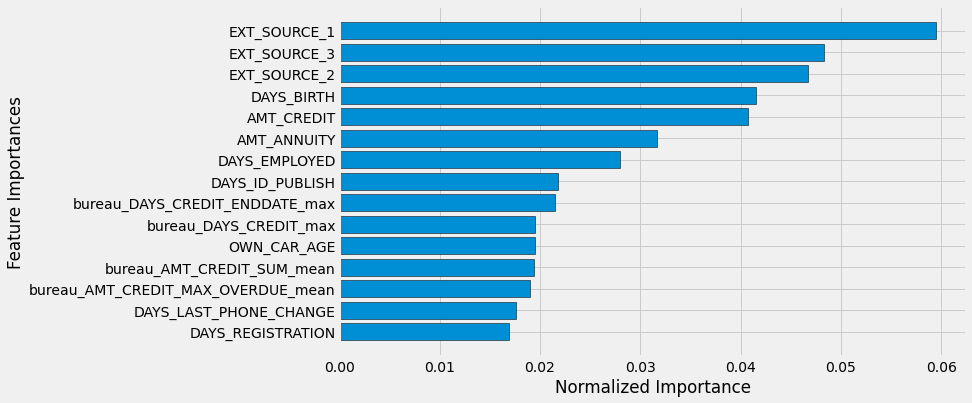

In [45]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [46]:
submission_corrs.to_csv('test_two.csv', index = False)